In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import sklearn
%matplotlib inline
data_path = '/Users/dirlt/.kaggle/competitions/bike-sharing-demand/'

# Load Data

In [2]:
def extend_fields(df, as_float = False):
    df = df.copy()
    dt = df['datetime']
    dt2 = pd.to_datetime(dt)
    df['dt_day'] = dt2.apply(lambda x: x.day)
    df['dt_weekday'] = dt2.apply(lambda x: x.weekday())
    df['dt_month'] = dt2.apply(lambda x: x.month)
    df['dt_hour'] = dt2.apply(lambda x: x.hour)
    df['dt_year'] = dt2.apply(lambda x: x.year)
    df['dt_day2'] = dt2.apply(lambda x: '{}-{}-{}'.format(x.year, x.month, x.day))
    x = df
    if not as_float:
        x['temp'] = np.round(x['temp']).astype(int)
        x['atemp'] = np.round(x['atemp']).astype(int)
        x['humidity'] = np.round(x['humidity']).astype(int)
        x['windspeed'] = np.round(x['windspeed']).astype(int)
    tmp = pd.get_dummies(x['season'], prefix = 'season')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['weather'], prefix = 'weather')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['dt_weekday'], prefix = 'weekday')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['dt_month'], prefix = 'month')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['dt_hour'], prefix = 'hour')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['dt_year'], prefix = 'year')
    x = x.join(tmp)
    return x

In [3]:
ogn_df = pd.read_csv(data_path + 'train.csv')
df = extend_fields(ogn_df)

In [4]:
ogn_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [5]:
def group_plot(group_fields, value_fields = ['casual', 'registered']):
    df.groupby(group_fields)[value_fields].sum().plot(kind = 'bar', figsize = (10, 6))

# count 出现异常值

使用boxplot和distplot来观察分布情况

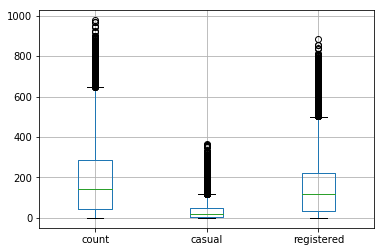

In [6]:
df.boxplot(['count', 'casual', 'registered'])

In [7]:
def _smooth_count(x, field):
    x2 = x.groupby('dt_day2').apply(lambda x: pd.Series.rolling(x[field], window = 3, center=True).mean())
    x2.index = x.index
    x2[x2.isnull()] = x.loc[x2.isnull(), field]
    x[field + "_2"] = np.round(x2).astype(np.int)
    return x

def smooth_count(x):
    _smooth_count(x, 'casual')
    _smooth_count(x, 'registered')
    x['count_2'] = x['casual_2'] + x['registered_2']
    return x
    
def filter_count_outlier(x, test = False):
    if test: return x    
#     x = x[x['count'] <= 600]
#     x = x[x['registered'] <= 400]
#     x = x[x['casual'] <= 100]
    return x
df = filter_count_outlier(df)

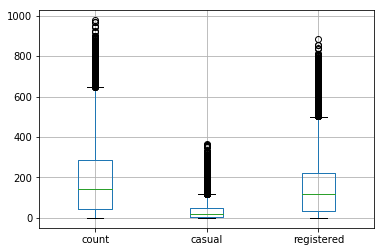

In [8]:
df.boxplot(['count', 'casual', 'registered'])

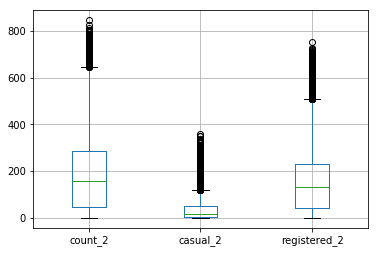

In [9]:
# 平滑下来之后效果比较差
tmp_df = df.copy()
tmp_df = smooth_count(tmp_df)
tmp_df.boxplot(['count_2', 'casual_2', 'registered_2'])

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


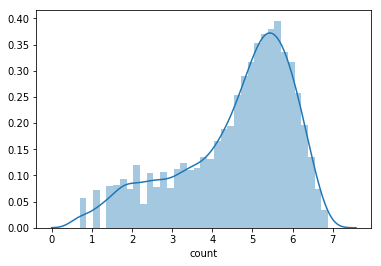

In [10]:
sns.distplot(np.log1p(df['count']))

# 体感温度的修正

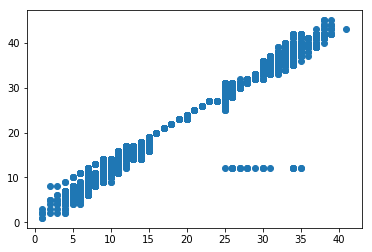

In [11]:
plt.scatter(df['temp'], df['atemp'])

In [12]:
def fix_atemp(x):
    atemp_outliner = (x['temp'] / x['atemp'] > 2.0)
    x.loc[atemp_outliner, 'atemp'] = x.loc[atemp_outliner, 'temp']
    x['atemp'] = x['atemp'].astype(int)
    return x
df = fix_atemp(df)

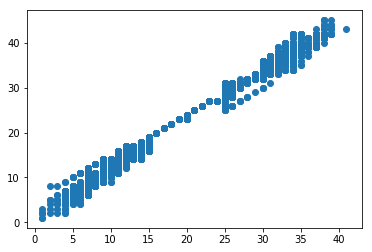

In [13]:
plt.scatter(df['temp'], df['atemp'])

可以看到atemp分布不太均匀，temp相对还比较均匀一些。所以特征的话最好还是用temp

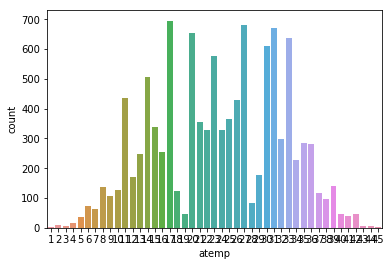

In [14]:
sns.countplot('atemp', data = df)

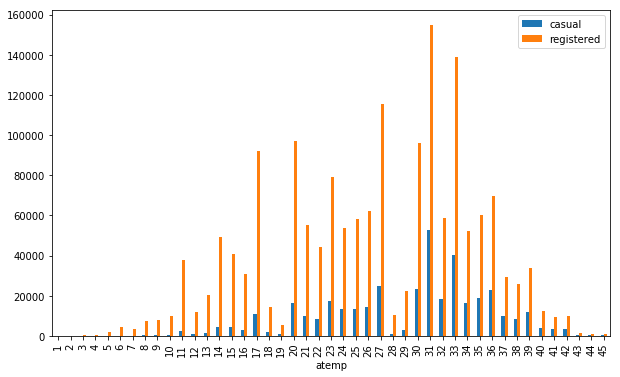

In [15]:
group_plot('atemp')

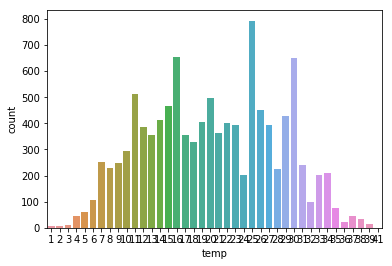

In [16]:
sns.countplot('temp', data = df)

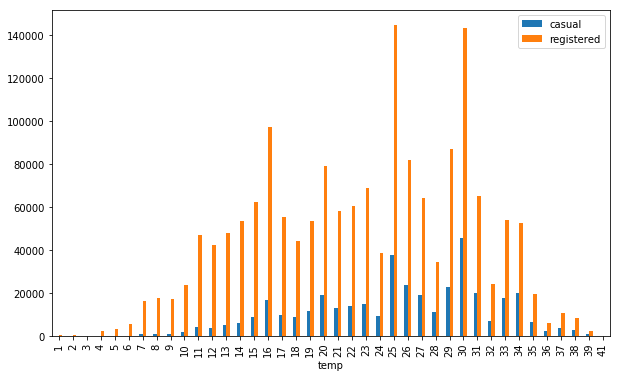

In [17]:
group_plot('temp')

# hour分布情况

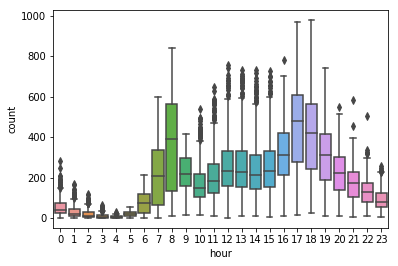

In [18]:
df['hour'] = df['dt_hour'].astype('category')
sns.boxplot(data = df, x = 'hour', y = 'count')

casual: 如果左移4个单位的话可以看到非常对称

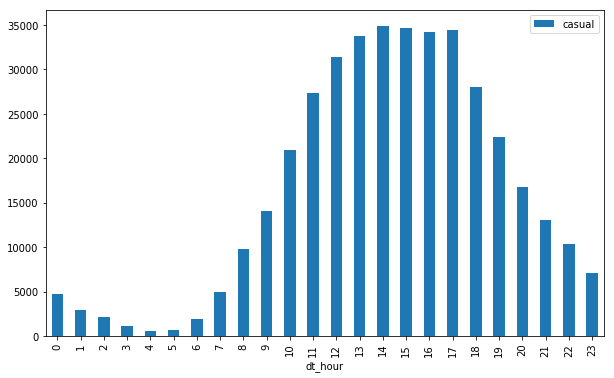

In [19]:
group_plot('dt_hour', value_fields=['casual'])

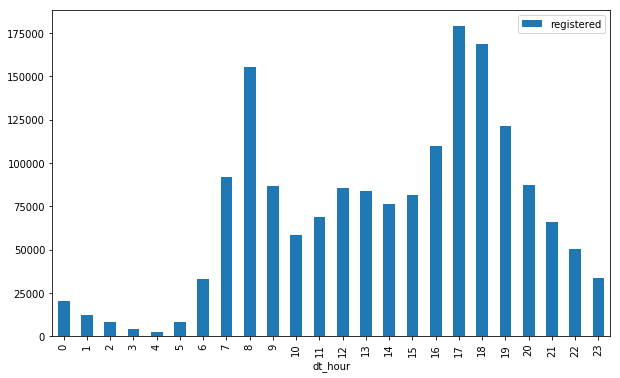

In [20]:
group_plot('dt_hour', ['registered'])

# winspeed异常

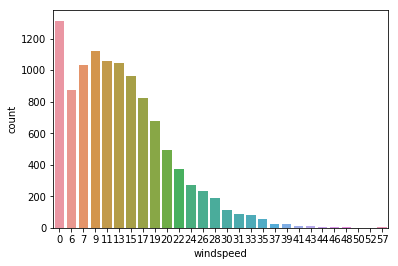

In [21]:
sns.countplot(df['windspeed'])

In [22]:
def mark_windspeed(x):
    x['windspeed_0'] = 0
    x.loc[(np.round(x['windspeed']).astype(int) == 0),'windspeed_0'] = 1
    return x
df = mark_windspeed(df)

In [23]:
df['windspeed'].describe()

count    10886.000000
mean        12.799100
std          8.164634
min          0.000000
25%          7.000000
50%         13.000000
75%         17.000000
max         57.000000
Name: windspeed, dtype: float64

# humidity异常

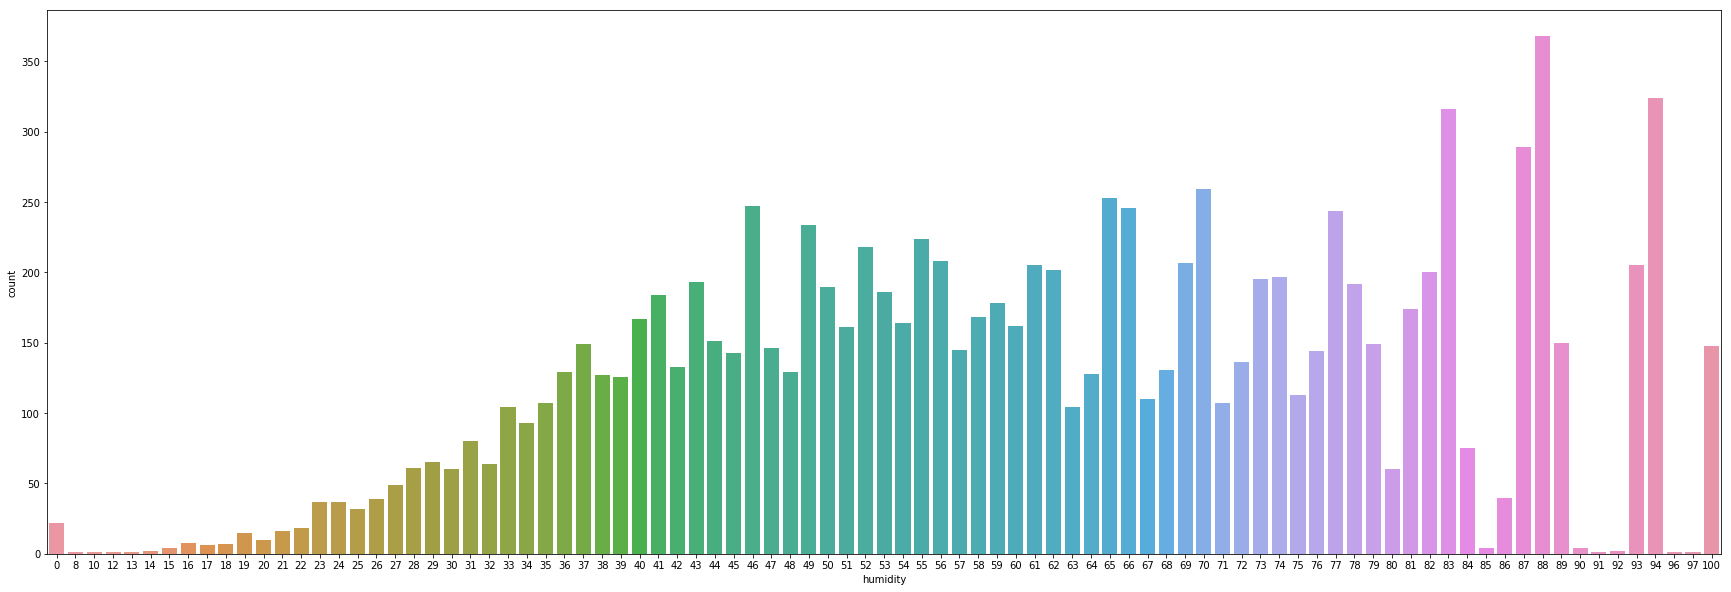

In [24]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(30)
sns.countplot('humidity', data = df, ax = ax)

In [25]:
df['humidity'].describe(percentiles = np.arange(0, 1, 0.1))

count    10886.000000
mean        61.886460
std         19.245033
min          0.000000
0%           0.000000
10%         37.000000
20%         44.000000
30.0%       50.000000
40%         56.000000
50%         62.000000
60.0%       68.000000
70%         74.000000
80%         81.000000
90%         88.000000
max        100.000000
Name: humidity, dtype: float64

In [26]:
def mark_humidity(x):
    h = np.round(x['humidity']).astype(int)
    x['humidity_0'] = 0
    x.loc[h == 0, 'humidity_0'] = 1
    x['humidity_1'] = 0 
    x.loc[(h >= 85) & (h <=92), 'humidity_1'] = 1
    x['humidity_2'] = 0
    x.loc[(h >92) & (h < 100), 'humidity_2'] = 1
    x['humidity_3'] = 0
    x.loc[h == 100, 'humidity_3'] = 1
    return x
df = mark_humidity(df)

# humidity, temp, windspeed关系

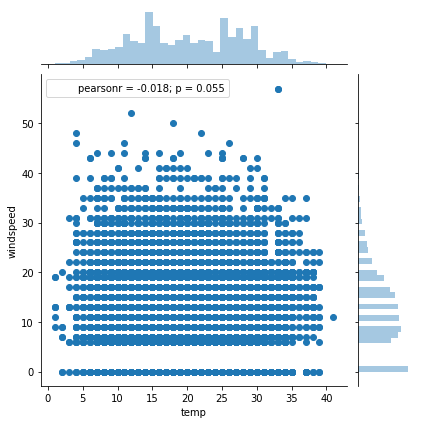

In [27]:
sns.jointplot('temp', 'windspeed', data = df)

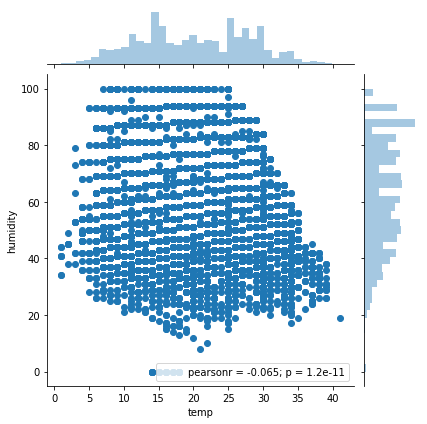

In [28]:
sns.jointplot('temp', 'humidity', data = df)

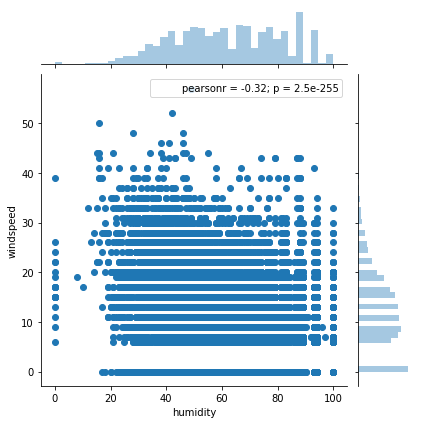

In [29]:
sns.jointplot('humidity', 'windspeed', data = df)

# 输出features

In [30]:
def select_features(df, test = False):
    columns = ['holiday', 'workingday',  'casual', 'registered',
               'count', 'dt_month', 'dt_day', 'dt_hour',
               'temp', 'humidity', 'windspeed', 'atemp',
               'season', 'dt_weekday', 'weather', 'dt_year', 'windspeed_0',
               'humidity_0', 'humidity_1', 'humidity_2', 'humidity_3']
    columns.extend(['season_{}'.format(x) for x in range(1,5)])
    columns.extend(['weather_{}'.format(x) for x in range(1,5)])
    columns.extend(['weekday_{}'.format(x) for x in range(0, 7)])
    columns.extend(['month_{}'.format(x) for x in range(1, 13)])
    columns.extend(['year_{}'.format(x) for x in range(2011, 2013)])
    columns.extend(['hour_{}'.format(x) for x in range(0, 24)])

    if test:
        columns.remove('count')
        columns.remove('casual')
        columns.remove('registered')
        columns.insert(0, 'datetime')
    
    if not test:
        # 对casual以及registered做平滑处理
        if 'count_2' in df.columns:
            df['count'] = df['count_2']
            df['casual'] = df['casual_2']
            df['registered'] = df['registered_2']
    return df[columns]

In [31]:
train_df = pd.read_csv(data_path + 'train.csv')
train_df = extend_fields(train_df, as_float=True)
train_df = filter_count_outlier(train_df)
train_df = mark_windspeed(train_df)
train_df = mark_humidity(train_df)
output_df = select_features(train_df)
output_df.to_csv('mytrain.csv', index=False)

In [32]:
test_df = pd.read_csv(data_path + 'test.csv')
test_df = extend_fields(test_df, as_float=True)
test_df = mark_windspeed(test_df)
test_df = mark_humidity(test_df)
test_output_df = select_features(test_df, test=True)
test_output_df.to_csv('mytest.csv', index = False)